In [12]:
# from bokeh.plotting import figure
# from bokeh.io import show, output_notebook
# from bokeh.layouts import column, row
# from bokeh.models import Range1d
# output_notebook()

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 50})

%matplotlib inline

import seaborn as sns
sns.set(font_scale=3)
sns.set_style('ticks')

import numpy as np
from scipy import signal

from resistingrhythm.util import poisson_impulse
from resistingrhythm.util import poisson_oscillation
from resistingrhythm.util import current_pulse
from resistingrhythm.util import load_spikes
from resistingrhythm.util import create_times
from resistingrhythm.util import poisson_hippocampus_theta
from resistingrhythm.neurons import HHH

from fakespikes import neurons, rates
from fakespikes import util as fsutil

import warnings
warnings.filterwarnings("ignore")

# Load data

In [2]:
lfp_raw = np.load('/Users/qualia/Code/resistingrhythm/resistingrhythm/data/ca1.npy')

sampling_rate = 1252
lfp_times = np.arange(0, len(lfp_raw)/sampling_rate, 1/sampling_rate)
f_theta = (4, 10)

# Select a window of data

to work with throughout

In [3]:
max_t = 20
m = lfp_times <= max_t

lfp_times = lfp_times[m]
lfp_raw = lfp_raw[m]

In [4]:
lfp_raw.shape, lfp_times.shape

((25041,), (25041,))

## Resampling

In [5]:
lfp_sampled = signal.resample(lfp_raw, int((lfp_raw.size / sampling_rate)*1000))
lfp_sampled_times = np.arange(0, len(lfp_sampled)/1000, 1/1000)

In [6]:
lfp_raw.shape, lfp_sampled.shape

((25041,), (20000,))

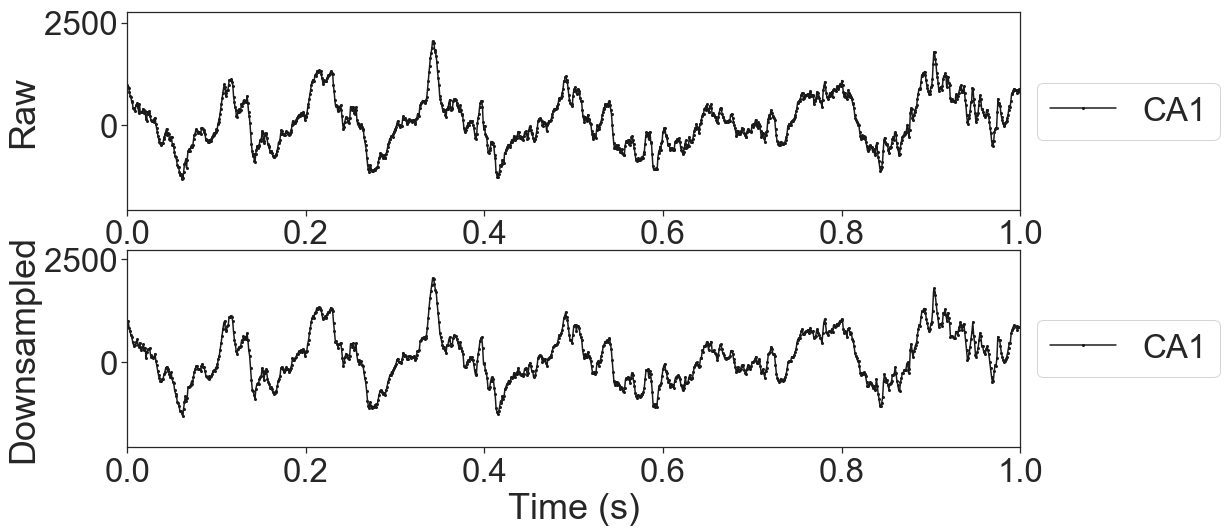

In [7]:
fig, ax = plt.subplots(2, figsize=(16, 8))

_ = ax[0].plot(lfp_times, lfp_raw, markersize=2, marker='o', linestyle='-', color='k', label='CA1')
_ = ax[0].set_xlabel("Time (s)")
_ = ax[0].set_ylabel("Raw")
_ = ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax[0].set_xlim(0, 1)

_ = ax[1].plot(lfp_sampled_times, lfp_sampled, markersize=2, marker='o', linestyle='-', color='k', label='CA1')
_ = ax[1].set_xlabel("Time (s)")
_ = ax[1].set_ylabel("Downsampled")
_ = ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax[1].set_xlim(0, 1)

# Visual LFP

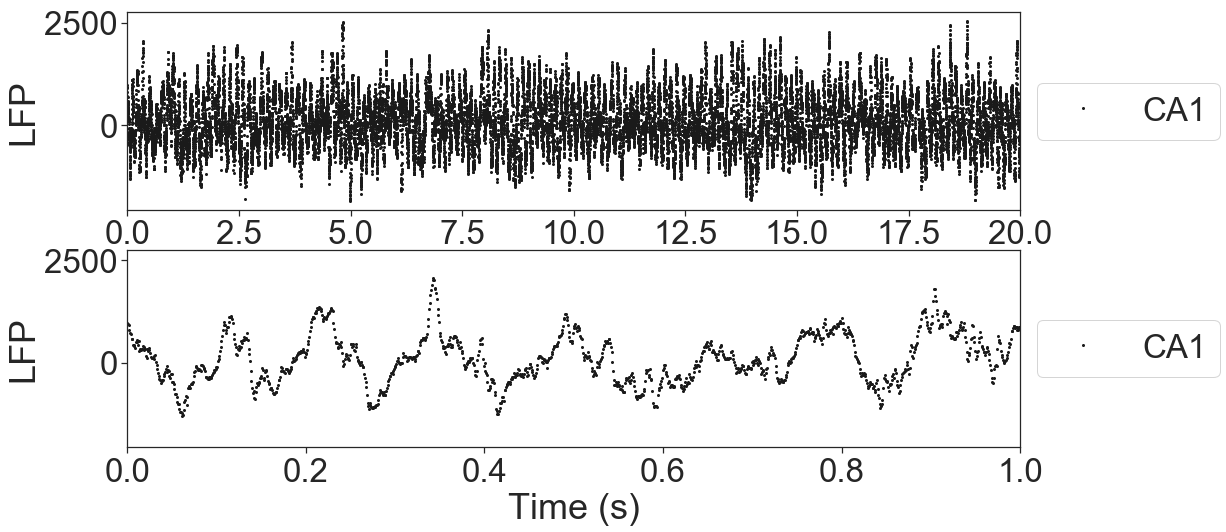

In [10]:
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(2, figsize=(16, 8))

# Drives
_ = ax[0].plot(lfp_times, lfp_raw, markersize=2, marker='o', linestyle='', color='k', label='CA1')
_ = ax[0].set_xlabel("Time (s)")
_ = ax[0].set_ylabel("LFP")
_ = ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax[0].set_xlim(0, 20)

_ = ax[1].plot(lfp_times, lfp_raw, markersize=2, marker='o', linestyle='', color='k', label='CA1')
_ = ax[1].set_xlabel("Time (s)")
_ = ax[1].set_ylabel("LFP")
_ = ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax[1].set_xlim(0, 1)

# Poisson firing

For the lfp

In [11]:
# Poisson sample the rate over w
t = lfp_times.max()
n = 1000
osc_rate = 3
dt = 1 / sampling_rate

# Init
nrns = neurons.Spikes(n, t, dt=dt, refractory=dt, seed=None)

# Normalize lfp -> (0, 1)
drive = (lfp_raw - np.min(lfp_raw)) / (np.max(lfp_raw) - np.min(lfp_raw)) 

# Make spikes
firing_rate = nrns.poisson(osc_rate * drive[0:-1])
ns, ts = fsutil.to_spiketimes(lfp_times[0:-1], firing_rate)

### Visualize

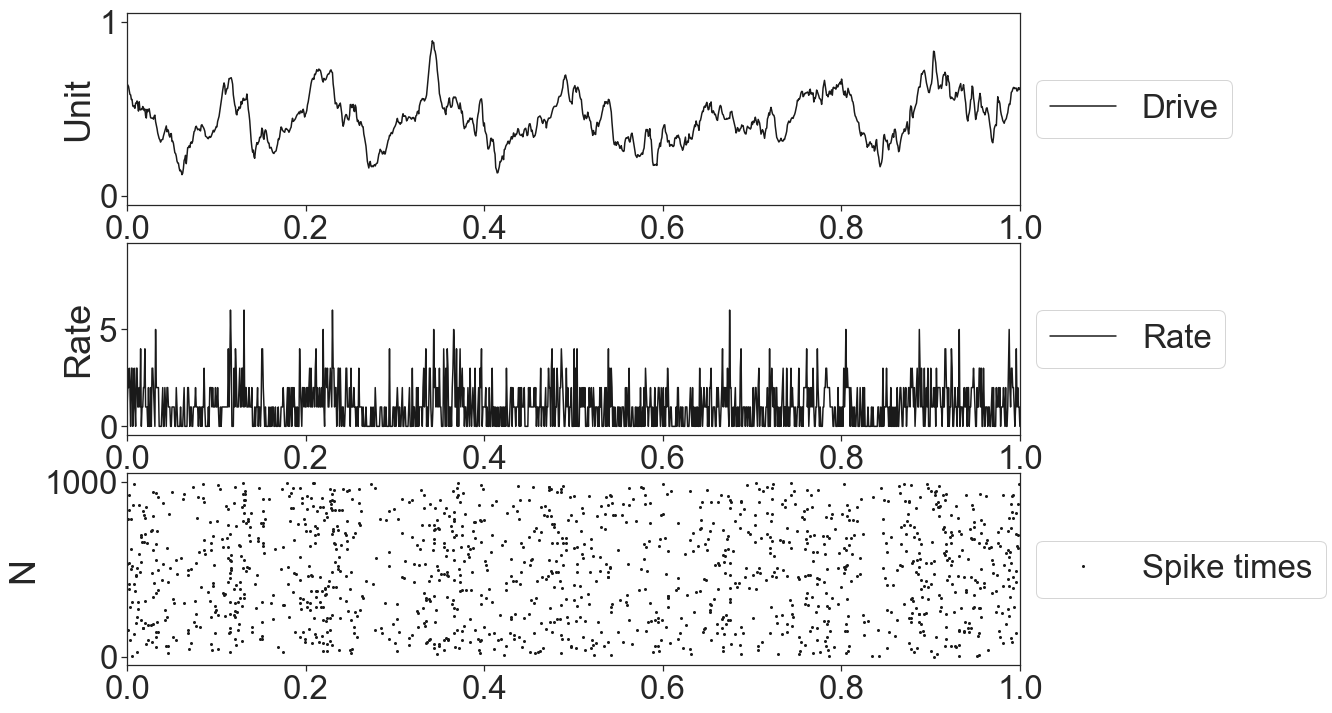

In [12]:
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(3, figsize=(16, 12))

_ = ax[0].plot(lfp_times, drive, marker='', linestyle='-', color='k', 
               label='Drive')
_ = ax[0].set_ylabel("Unit")
_ = ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax[0].set_xlim(0, 1)

_ = ax[1].plot(lfp_times[0:-1], firing_rate.sum(1), marker='', linestyle='-', color='k', 
               label='Rate')
_ = ax[1].set_ylabel("Rate")
_ = ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax[1].set_xlim(0, 1)

_ = ax[2].plot(ts, ns, markersize=2, marker='o', linestyle='', color='k', 
               label='Spike times')
_ = ax[2].set_ylabel("N")
_ = ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax[2].set_xlim(0, 1)

# Testing the util

The code above was part of developing `resistingrhythm.util.poisson_hippocampus_theta`

So let's test that function too.

In [50]:
ns, ts = poisson_hippocampus_theta(
    t=20, 
    t_onset=1, 
    n_cycles=22*8,
    rate=1.5,
    n=1000,
    dt=1e-3)

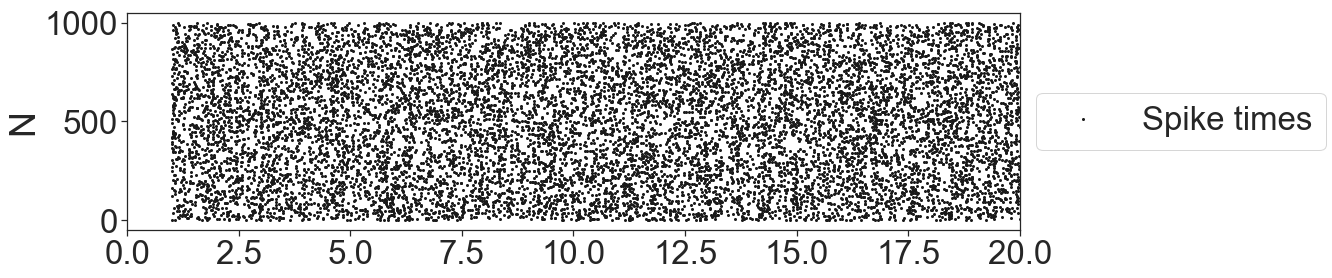

In [51]:
fig, ax = plt.subplots(1, figsize=(16, 4))
_ = ax.plot(ts, ns, markersize=2, marker='o', linestyle='', color='k', 
               label='Spike times')
_ = ax.set_ylabel("N")
_ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax.set_xlim(0, 20)

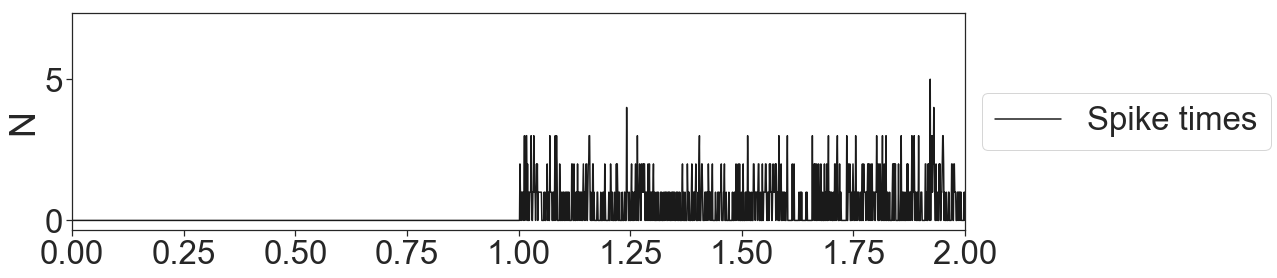

In [52]:
fig, ax = plt.subplots(1, figsize=(16, 4))
_ = ax.plot(
    fsutil.create_times(20, dt=1e-3)[1:],
    fsutil.bin_times(ts, (0, 20), dt=1e-3)[1].flatten(), 
    markersize=2, color='k', label='Spike times')
_ = ax.set_ylabel("N")
_ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax.set_xlim(0, 2)

Compare to sine wave.

In [94]:
ns, ts = poisson_oscillation( 
    t=20, 
    t_onset=19.5, 
    n_cycles=3,
    rate=12,
    n=1000,
    f=150,
    dt=1e-3)

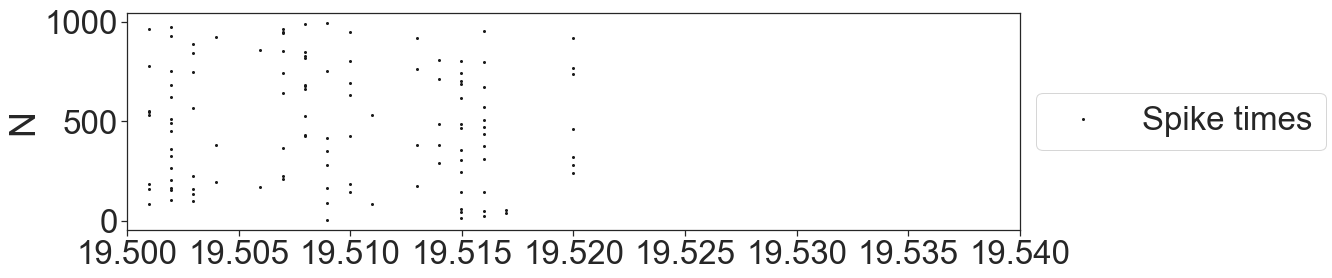

In [95]:
fig, ax = plt.subplots(1, figsize=(16, 4))
_ = ax.plot(ts, ns, markersize=2, marker='o', linestyle='', color='k', 
               label='Spike times')
_ = ax.set_ylabel("N")
_ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax.set_xlim(19.5, 19.54)

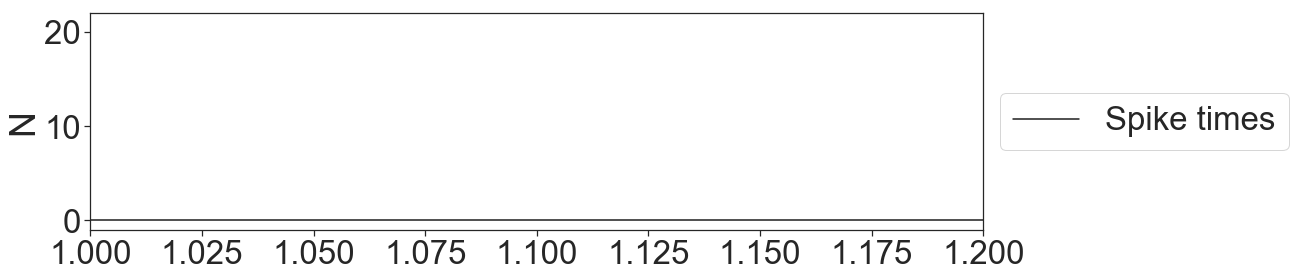

In [74]:
fig, ax = plt.subplots(1, figsize=(16, 4))
_ = ax.plot(
    fsutil.create_times(20, dt=1e-3)[1:],
    fsutil.bin_times(ts, (0, 20), dt=1e-3)[1].flatten(), 
    markersize=2, color='k', label='Spike times')
_ = ax.set_ylabel("N")
_ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax.set_xlim(1, 1.2)